# Using a pre-trained Convolutional Neural Network for classification of masses and calcifications in mammogram images

Fabio D'Onofrio

matricola : 556505

Università degli studi di Pisa

Progetto del corso di Computational Intelligence

This Notebook includes $three$ $sections$.

The $first$ $section$ includes setting of the Drive directory in which mammogram images(both training set and test set) are stored, already preprocecced and patched, as numpy arrays with float values in the range 0-65535 and labels(0 corresponds to masses while 1 indicates calcification). In this section useful modules are also imported and some functions are defined in order to be used in the next two sections.

In the $second$ $section$ an interactive procedure of hyperparameters searching is implemented, allowing the user to test many different CNN architectures by setting a few parameters such as the prtrained convolutional base(Xception,VGG16,etc) and numbers of fully connected layers' neurons, optimization algorithm and data augmentation,fine tuning and so on. This section has been used iteratively to store training results of different CNNs in the working directory, to be used to search for the models which gave the best accuracies on the test set.

Finally the $third$ $section$ includes the proposed solution for the task, which consists in the best CNN among those that have been trained.


# SECTION 1 : Set the environment and download the data

In [0]:
#@title Set the working directory
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

data_dir = './drive/My Drive/Computational Intelligence 2019/FinalProject/'

Mounted at /content/drive/


In [0]:
#@title Import modules
#@markdown --- **os** for operating system dependent functionality
import os
#@markdown --- **json** to use JSON data-interchange format
import json
#@markdown --- **numpy** to handle multidimensional data
import numpy as np
#@markdown --- **matplotlib** for figures
import matplotlib.pyplot as plt
#@markdown --- **keras** deep learning library
from   keras import models
from   keras import layers
from   keras.callbacks import EarlyStopping
from   keras.callbacks import ModelCheckpoint
from   keras.preprocessing.image import ImageDataGenerator
from   keras.models import load_model
from   keras import optimizers as opt
from   keras import applications as app
from   keras import Model
#@markdown --- **random** to generate pseudo-random numbers
import random as rn

In [0]:
#@title Class data_setting 
class data_setting :
#@markdown ---Member variables: **train_data, train_labels, test_data, test_labels**     
    def __init__(self,train_data,train_labels,test_data,test_labels):
        # Initialization with data loaded with numpy.load
        self.train_data = train_data
        self.train_labels = train_labels
        self.test_data = test_data
        self.test_labels = test_labels
#@markdown ---Method **shuffleDataset()** shuffles the data set    
    def shuffleDataset(self):
    # This method shuffles the training data set       
        dataset=list(zip(self.train_data,self.train_labels))        
        rn.shuffle(dataset)
        self.train_data=np.array(list(zip(*dataset))[0])
        self.train_labels=np.array(list(zip(*dataset))[1])
#@markdown ---Method **data_manipulation()** reshapes and normalizes training and test sets    
    def data_manipulation(self) :
        # This method shuffles,reshapes, and normalizes the given training and test sets
        bits_per_pixel = 16
        train_data_shape = np.shape(self.train_data) 
        ex_number = train_data_shape[0]
        pix_width = train_data_shape[1]
        pix_height = train_data_shape[2]

        self.shuffleDataset()

        self.train_data = self.train_data.reshape(ex_number,pix_width,pix_height,1)
        self.train_data = self.train_data.astype('float32')/(np.power(2,bits_per_pixel)-1)

        test_examples = len(self.test_data)

        self.test_data = self.test_data.reshape(test_examples,pix_width,pix_height,1)
        self.test_data = self.test_data.astype('float32')/(np.power(2,bits_per_pixel)-1)
        
        self.train_data = self.train_data*np.ones((len(self.train_data),1,1,3))   
        self.test_data =  self.test_data*np.ones((len(self.test_data),1,1,3))   
    
##############################################################################

In [0]:
#@title Class PT_CNN_Hyperparameters
##############################################################################
class PT_CNN_Hyperparameters(data_setting) :
  
  def __init__(self,train_data,train_labels,test_data,test_labels) :
    super().__init__(train_data,train_labels,test_data,test_labels)
#@markdown ---Method **set_opt_lr()** builds a keras optimizer from an optimization algorithm and the desired learning rate  
  def set_opt_lr(self,optimizer,lr) :
  # This method sets the optimization algorithm and the learning rate      
    optimizers = ['SGD','RMSprop','Adagrad','Adadelta','Adam','Adamax','Nadam']
    keras_opt  = [opt.SGD,opt.RMSprop,opt.Adagrad,opt.Adadelta,opt.Adam,opt.Adamax,opt.Nadam]    
      
    if lr == 'default' :
        return keras_opt[optimizers.index(optimizer)]() # default lr
    else :
        return keras_opt[optimizers.index(optimizer)](lr=lr)
#@markdown ---Method **set_pt_model()** returns a keras pre-trained model from its string name
  def set_pt_model(self,pt_model) :
    
    pretrained_models       = ['Xception' , 'VGG16' , 'VGG19'  , 'MobileNetV2' ,'DenseNet121']
    keras_pt_models         = [app.Xception, app.VGG16 , app.VGG19 , app.MobileNetV2 , app.DenseNet121 ]
    keras_preprocess_inputs = [app.xception.preprocess_input,app.vgg16.preprocess_input ,\
                               app.vgg19.preprocess_input , app.mobilenet_v2.preprocess_input , app.densenet.preprocess_input ]
    return keras_pt_models[pretrained_models.index(pt_model)], keras_preprocess_inputs[pretrained_models.index(pt_model)]

#@markdown ---Method **data_aug_specs()** builds a keras ImageDataGenerator for data augmentation    
  def data_aug_specs(self,DA_specs,pt_model):
  # This method creates the ImageDataGenerator for data augmentation  
    if DA_specs[8] != None :
      keras_model , prep_func = self.set_pt_model(pt_model)
    else :
      prep_func = None
    
    datagen = ImageDataGenerator(
            featurewise_center=DA_specs[0],               
            featurewise_std_normalization=DA_specs[1],
            rotation_range=DA_specs[2],
            width_shift_range=DA_specs[3],
            height_shift_range=DA_specs[4],
            horizontal_flip=DA_specs[5],
            shear_range=DA_specs[6],
            zoom_range=DA_specs[7],
            preprocessing_function= prep_func)
    
    DA_specs_dict = {'featurewise_center':DA_specs[0],\
                    'featurewise_std_normalization':DA_specs[1],\
                    'rotation_range':DA_specs[2],\
                    'width_shift_range':DA_specs[3],\
                    'height_shift_range':DA_specs[4],\
                    'horizontal_flip':DA_specs[5],\
                    'shear_range':DA_specs[6],\
                    'zoom_range':DA_specs[7],\
                    'preprocessing_function': DA_specs[8] } 
    
    return datagen , DA_specs_dict
#@markdown ---Method **find_n_last_blocks()** returns the numbers corresponding to the last *n_blocks* of convolutional layers  
  def find_n_last_blocks(self, conv_layers , n_blocks) :
  #This method outputs the numbers of the last n_blocks conv. layers
    block_numbers = []
    for layer in conv_layers:
      layer_name = layer.get_config()['name']
      if 'block' in layer_name :
        block_number = layer_name[layer_name.index('k')+1:layer_name.index('_')]
        if int(block_number) not in block_numbers :
          block_numbers.append(int(block_number))

    last_block_numbers = sorted(block_numbers)[-n_blocks:]  
    
    return last_block_numbers
   
##############################################################################                 

In [0]:
#@title Class PT_CNN
class PT_CNN(PT_CNN_Hyperparameters) :
   
  def __init__(self,train_data,train_labels,test_data,test_labels) :        
    super().__init__(train_data,train_labels,test_data,test_labels)

#@markdown ---Method **generate_figures()** plots training history 
  def generate_figures(self,history,j,dir_name) :
  # This method generates and saves training and validation accuracy and loss histories

    plt.title('LOSS_'+str(j))
    plt.plot(history.history['loss'],'b--',label = 'Training loss')
    plt.plot(history.history['val_loss'],'r--',label = 'Validation loss')
    plt.legend()
    plt.savefig(dir_name+'loss_'+str(j)+'.png')
    plt.show()
    plt.title('ACCURACY_'+str(j))
    plt.plot(history.history['acc'],'b-',label = 'Training accuracy')
    plt.plot(history.history['val_acc'],'r-',label = 'Validation accuracy')
    plt.legend()
    plt.savefig(dir_name+'acc_'+str(j)+'.png')
    plt.show()
#@markdown ---Method **train_PT_model()** builds and trains one pre-trained CNN
  def train_PT_model(self, Mod_arch , Mod_train , remove_last_n_blocks , n_blocks_remove , fine_tuning_last_n_blocks , n_blocks_tune , save_best , j_ind , folder_name):   #  
    """
    Mod_arch=[ pt_model , FC_neurons ,FCActivation,OutputActivation] 4 elementi
    Mod_train=[ epochs, batch_size,validation_split,optimizer,lr,data_aug(True/False) if True anche, DA_specs(lista di 9 specifiche sul data augmentation)] 6/7 elementi
    """
  
  # This method builds and trains a pre-trained CNN specified through the six args Mod_arch , Mod_train , remove_last_n_blocks , n_blocks_remove , fine_tuning_last_n_blocks , n_blocks_tune
    #
    # INPUT ARGS
    #
    #  --- Mod_arch is a list of 4 elements that specifies the network's architecture ---
    #
    # Mod_arch         : [ pt_model , FC_neurons ,FCActivation,OutputActivation] 
    #
    # pt_model         : string name of a keras pretrained model--------------------( e.g. 'Xception')
    # FC_neurons       : list of numbers of fully connected layers' output neurons--( e.g. [256,512] )
    # ConvActivation   : activation function of convolutional layers----------------( e.g. 'relu' )
    # FCActivation     : activation function of fully connected layers -------------( e.g. 'relu' )
    # OutputActivation : activation function of the output layer--------------------( e.g. 'sigmoid' )
    #
    #  --- Mod_train is a list of 7 elements that specifies the learning process ---
    #
    # Mod_train : [ epochs, batch_size,validation_split,optimizer,lr,data_aug, DA_specs] 
    #
    # epochs           : number of training epochs------------------------------------------(e.g. 100)
    # batch_size       : dimension of the batch size----------------------------------------(e.g. 100)
    # validation_split : percentage of data used for validation-----------------------------(e.g. 0.1)
    # optimizer        : optimization algorithm---------------------------------------------(e.g. 'Adamax' )
    # lr               : optimization algorithm's learning rate-----------------------------(e.g. 1e-5)
    # data_aug         : boolean, True if data augmentation must be used, False otherwise---(e.g. True)
    #  --- DA_specs is a list of 9 elements that specifies the data augmentation's parameters ---
    # DA_specs         : [ featurewise_center , featurewise_std_normalization,rotation_range, width_shift_range,height_shift_range,
    #                      horizontal_flip,shear_range,zoom_range,preprocessing_function]
    # --------------------------------------------------------------------------------------(e.g. [False,False,20,0.2,0.2,True,20,0.2,app.xception.preprocess_input] )
    # remove_last_n_blocks      : boolean, True to remove the last n_blocks_remove blocks of layers from the pre-trained model's convolutional base
    # n_blocks_remove           : number of blocks that are removed if remove_last_n_blocks is True
    # fine_tuning_last_n_blocks : boolean, True to fine tuning the last n_blocks_tune blocks of layers from the pre-trained model's convolutional base
    # n_blocks_tune             : number of blocks to fine tuning if fine_tuning_last_n_blocks is True
    # save_best                 : boolean, True to save the best keras model in the training process, False otherwise
    # j_ind                     : subscript to label models
    # folder_name               : folder in the working directory in which to save the best model if save_model is True
    #
    # OUTPUT ARGS
    #
    # model ----------------- keras model compiled and trained
    # history --------------- training history dictionary
    # model_architecture ---- a string containing the main informations on the network's architecture and training process
    # model_dict ------------ a dictionary containing network informations 
    #
    # The CNN architecture will be of the type [Pretrained Conv. base(such as Xception or VGG16)]->[FC -> RELU]*K -> FC
  
    input_shape = (np.shape(self.train_data)[1],np.shape(self.train_data)[2],3)
    
    pt_model , FC_neurons ,FCActivation, OutputActivation = Mod_arch 
    
    epochs, batch_size,validation_split,optimizer_alg,learn_rate,data_aug = Mod_train[:6]
    
    optimizer = self.set_opt_lr(optimizer_alg,learn_rate)
    
    keras_pt_model , prep_func = self.set_pt_model(pt_model) 
    
    conv_base = keras_pt_model(weights='imagenet',
                      include_top=False,
                      input_shape=input_shape) 
    
    model_architecture = 'Convolutional base : {}\n'.format(pt_model)

    FC_layer_descr = '--- FC layer({}) with {} units '

    model = models.Sequential()
    conv_base.trainable = False
    conv_base.compile(optimizer=optimizer,
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
    
    model_dict={'mod_arch':{'Convolutional base':{},'FC':{},'act_funcs':{}} ,\
                'mod_training' : {'fine_tuning':{} , 'remove_blocks' :{} }}
    
    patience=10
    early_stopping_train_loss = EarlyStopping(monitor='loss',mode='auto', patience=patience) # stop training when training loss doesn't decrease for 10 consecutives epochs
    early_stopping_val_loss =   EarlyStopping(monitor='val_acc',mode='auto', patience=10)
    cb = [early_stopping_train_loss,early_stopping_val_loss]
    
    if save_best==True :
          
      dir_name = data_dir + folder_name + '/'

      if not os.path.exists(dir_name) :
        os.mkdir(dir_name)

      save_best_model = ModelCheckpoint(dir_name+'best_'+str(j_ind)+'.h5', monitor='val_loss' , save_best_only=True , mode='auto', period=1)
      cb.append(save_best_model)    

    model_dict['mod_training'] = {'epochs' : epochs, 'batch_size' : batch_size, 'opt_alg' : { 'algorithm' : optimizer_alg, 'learning rate' : learn_rate } , 'val_split' : validation_split,\
                                  'data_aug' : data_aug ,'early_stopping' : {'monitor':early_stopping_train_loss.monitor , 'patience' : early_stopping_train_loss.patience }}
    
    if fine_tuning_last_n_blocks == False :
      model_dict['mod_training']['fine_tuning']={'fine_tuning' : False , 'blocks_tuned' : 0 }
      model_architecture += 'Fine tuning : False\n'
    
    if remove_last_n_blocks == True :
      model_dict['mod_training']['remove_blocks']={'remove_blocks':True,'blocks_removed' : n_blocks_remove }
      last_block_to_remove = self.find_n_last_blocks(conv_base.layers , n_blocks_remove)
      print('removing the {} lasts layers blocks '.format(n_blocks_remove))
      model_architecture += 'Removing last block of layers\n'

      layers_to_remove = 0
      
      for layer in conv_base.layers:
        for block_number in last_block_to_remove :
          if 'block'+str(block_number) in layer.name :
            layers_to_remove += 1
            
      if  fine_tuning_last_n_blocks == False :
        
        name=pt_model + '_ConvBase'
        model.add(Model(inputs=conv_base.input, outputs=conv_base.layers[-layers_to_remove-1].output,name=name,trainable=False))  
        model.trainable= False
        model.compile(optimizer=optimizer,
                        loss='binary_crossentropy',
                        metrics=['accuracy'])
      else :
        model_dict['mod_training']['fine_tuning']={'fine_tuning' : True , 'blocks_tuned' : n_blocks_tune }
        print('fine tuning the  {} lasts layers blocks '.format(n_blocks_tune))
        model_architecture += 'Fine tuning the last {} layers block\n'.format(n_blocks_tune)
        conv_base.trainable = True

        set_trainable = False

        last_block_numbers = self.find_n_last_blocks(conv_base.layers , n_blocks_tune)

        for layer in conv_base.layers:
          for block_number in last_block_numbers :
            if 'block'+str(block_number-n_blocks_remove) in layer.name :
              set_trainable = True
            if set_trainable:
              layer.trainable = True
            else:
              layer.trainable = False

        conv_base.compile(optimizer=optimizer,
                        loss='binary_crossentropy',
                        metrics=['accuracy'])
        name=pt_model + '_ConvBase'
        model.add(Model(inputs=conv_base.input, outputs=conv_base.layers[-layers_to_remove-1].output,name=name))
    
    else :
      model_dict['mod_training']['remove_blocks']={'remove_blocks':False,'blocks_removed' : 0 }
      if fine_tuning_last_n_blocks == True :
        model_dict['mod_training']['fine_tuning']={'fine_tuning' : True , 'blocks_tuned' : n_blocks_tune }
        print('fine tuning the  {} lasts layers blocks '.format(n_blocks_tune))
        model_architecture += 'Fine tuning the last {} layers block\n'.format(n_blocks_tune)
        conv_base.trainable = True

        set_trainable = False

        last_block_numbers = self.find_n_last_blocks(conv_base.layers , n_blocks_tune)

        for layer in conv_base.layers:
          for block_number in last_block_numbers :
            if 'block'+str(block_number) in layer.name :
              set_trainable = True
            if set_trainable:
              layer.trainable = True
            else:
              layer.trainable = False

        conv_base.compile(optimizer=optimizer,
                        loss='binary_crossentropy',
                        metrics=['accuracy'])
        name=pt_model + '_ConvBase'
        model.add(Model(inputs=conv_base.input, outputs=conv_base.layers[-1].output,name=name))
    
    #model.add(layers.BatchNormalization())
    model.summary()
                
    model.add(layers.Flatten())
    
    optimization_algorithm = 'Optimization algorithm : {} , Learing rate : {}\n'.format(optimizer_alg,learn_rate)
    model_architecture += optimization_algorithm
    
    model_dict={'mod_arch':{'Convolutional base':{},'FC':{},'act_funcs':{}} , 'mod_training' : {}}
    model_dict['mod_arch']['Convolutional base'] = pt_model
    model_dict['mod_arch']['act_funcs'] = {'FC_act' : FCActivation , 'Out_act' : OutputActivation}
    
    
    if data_aug == True:        
      model.add(layers.Dropout(0.5))
      model_architecture += '---50% dropout---\n'
   
    for i in range(len(FC_neurons)) :
      model.add(layers.Dense(FC_neurons[i],activation=FCActivation,trainable=True))
      model_architecture += FC_layer_descr.format(i+1,FC_neurons[i])
      model_dict['mod_arch']['FC']['FC_'+str(i+1)]={'out_ns':FC_neurons[i]}
      model.compile(optimizer=optimizer,
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

    # Output layer    
    model.add(layers.Dense(1,activation=OutputActivation,trainable=True))
    model_architecture += '--- One unit output layer ---'
    
    model.compile(optimizer=optimizer,
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
    
    model.summary()
        
    if data_aug == False :

        history=model.fit(self.train_data, self.train_labels, epochs=epochs, batch_size=batch_size,validation_split=validation_split, shuffle='true',callbacks=cb) 
        #history = {'acc' : 0.8 , 'loss' : 0.4 , 'val_acc' : 0.7 , 'val_loss' : 0.5 }
        return model , history , model_architecture , model_dict

    else :
        # Data augmentation
        
        datagen , DA_specs_dict = self.data_aug_specs(Mod_train[6] , pt_model)
            
        model_dict['mod_training']['data_aug_specs'] = DA_specs_dict
        
        val_index = rn.sample(range(len(self.train_data)) , int(len(self.train_data)*validation_split) )
        val_set = self.train_data[val_index]
        val_labels= self.train_labels[val_index]
        train_index = [ n for n in range(len(self.train_data)) if n not in val_index]
        train_set = self.train_data[train_index]
        train_labels = self.train_labels[train_index]

        datagen.fit(train_set)

        steps_per_epoch = 50
       
        history = model.fit_generator(datagen.flow(train_set,train_labels, batch_size),
                    steps_per_epoch=steps_per_epoch , epochs=epochs,validation_data=(val_set,val_labels), shuffle='true',callbacks=cb)

    return model , history , model_architecture , model_dict
##################################################################################################################################################################################
##################################################################################################################################################################################
#@markdown --- Method **PT_create_models_and_plots()** trains one or more pre-trained CNNs storing results in the working directory   
  def PT_create_models_and_plots(self,  folder_name , Mod_arch , Mod_train , save_last , save_best , j , remove_last_n_blocks , n_blocks_remove , fine_tuning_last_n_blocks , n_blocks_tune ) :
  # This method is used to call the PT_train_model method to build and train pretrained CNNs 
    # It also save results and models' characteristics in the folder specified by arg folder_name :
    # Figure 1                : training and validation loss histories
    # Figure 2                : training and validation accuracy histories
    # models_descriptions.txt : a txt file containing descriptions of all models trained
    # model_dict              : a dictionary containing CNN's info for each model trained    
    #
    # INPUT ARGS
    #
    # folder_name      : the folder in the working directory in which result are saved
    #
    # Mod_arch         :   [ pt_model , FC_neurons ,FCActivation,OutputActivation] 
    #
    # pt_model         : list of string names of a keras pretrained models--------------------( e.g. ['Xception','VGG16','VGG19'] )
    # FC_neurons       : list of lists of numbers of fully connected layers' output neurons---( e.g. [[256],[256,256],[256,512]]  )
    # ConvActivation   : activation function of convolutional layers--------------------------( e.g. 'relu' )
    # FCActivation     : activation function of fully connected layers -----------------------( e.g. 'relu' )
    # OutputActivation : activation function of the output layer------------------------------( e.g. 'sigmoid' )
    #
    # Mod_train : [ epochs, batch_size,validation_split,optimizer,lr,data_aug, DA_specs] 
    #
    # epochs           : number of training epochs------------------------------------------(e.g. 100)
    # batch_size       : dimension of the batch size----------------------------------------(e.g. 100)
    # validation_split : percentage of data used for validation-----------------------------(e.g. 0.1)
    # optimizer        : list of optimization algorithms------------------------------------(e.g. ['RMSprop','Adamax'] )
    # lr               : list of learning rates for each opt. algorithm---------------------(e.g. [['default',1e-5] , [1e-4] ] )
    # data_aug         : boolean, True if data augmentation must be used, False otherwise---(e.g. True)
    #  --- DA_specs is a list of lists of 9 elements that specifies the data augmentation's parameters ---
    # DA_specs[i]      : [ featurewise_center , featurewise_std_normalization,rotation_range, width_shift_range,height_shift_range,
    #                      horizontal_flip,shear_range,zoom_range,preprocessing_function]
    # ---------(e.g. [ [False,False,20,0.2,0.2,True,20,0.2,app.xception.preprocess_input] , [True,True,60,0.4,0.4,False,20,0.2,None] ] )
    #
    # save_last                 : boolean, True to save keras model on the last training epoch performed in a .h5 file, False otherwise
    # save_best                 : boolean, True to save the best keras model in the training process, False otherwise
    # j                         : subscript to label files
    # remove_last_n_blocks      : boolean, True to remove the last n_blocks_remove blocks of layers from the pre-trained model's convolutional base
    # n_blocks_remove           : number of blocks that are removed if remove_last_n_blocks is True
    # fine_tuning_last_n_blocks : boolean, True to fine tuning the last n_blocks_tune blocks of layers from the pre-trained model's convolutional base
    # n_blocks_tune             : number of blocks to fine tuning if fine_tuning_last_n_blocks is True
    #
    # OUTPUT ARGS
    #
    # models_dict -------- dictionary with models' informations
    dir_name = data_dir + folder_name + '/'
    
    if not os.path.exists(dir_name) :
      os.mkdir(dir_name)
    
    pt_models , FC_neurons_comb ,FCActivation, OutputActivation = Mod_arch[0] ,Mod_arch[1] , Mod_arch[2], Mod_arch[3]
    
    epochs, batch_size,validation_split,optimizer_algs,learn_rates,data_aug = Mod_train[0] ,Mod_train[1] , Mod_train[2], Mod_train[3] , Mod_train[4] , Mod_train[5]
    
    models_dict = {}
    
    if j==1 :
      write_mode = 'w'
    else :
      write_mode = 'a'
      
    with open(os.path.join(dir_name,'Models_descriptions.txt'), mode=write_mode) as mod_descr :    
      
      if j==1 :      
        mod_descr.write('Testing different pretrained models with:\n\nConvolutional base : {}\nFully connected layers activation function : {}\nOutput layer activation function : {}\nOptimizer : {}, learning rate : {}\nNumber of epochs : {}\nbatch size : {}\nvalidation split : {}\ndata augmentation : {}\n'.format(pt_models,FCActivation,OutputActivation,optimizer_algs,learn_rates,epochs, batch_size,validation_split,data_aug))                              
      
      for pt_model in pt_models : 
        
        for optimizer_alg in optimizer_algs :

          for learn_rate in learn_rates[optimizer_algs.index(optimizer_alg)] :
            
            for FC_neurons in FC_neurons_comb :
              
              arch = [pt_model , FC_neurons , FCActivation , OutputActivation ]

              train = [ epochs, batch_size, validation_split, optimizer_alg , learn_rate , data_aug ]
              
              if data_aug == True :
                train.append(Mod_train[6])
              else :
                train.append([0])

              for da_specs in train[6] :
                
                train_i = train[0:6] + [da_specs]
                
                if data_aug == True :
                  mod_descr.write('featurewise_center : {} , featurewise_std_normalization : {}, rotation_range : {} , width_shift_range : {}, height_shift_range : {} , horizontal_flip : {},shear_range : {}, zoom_range : {}, preprocessing function : {}\n'.format(train_i[6][0],train_i[6][1],train_i[6][2],train_i[6][3],train_i[6][4],train_i[6][5],train_i[6][6],train_i[6][7],train_i[6][8]))                              
                   
                model , history , model_architecture , model_dict = self.train_PT_model( arch , train_i , remove_last_n_blocks , n_blocks_remove , fine_tuning_last_n_blocks , n_blocks_tune, save_best , j , folder_name )

                mod_descr.write('\n')
                mod_descr.write('Model {}\n'.format(j))
                mod_descr.write(model_architecture)                
    
                self.generate_figures(history,j,dir_name)

                test_loss, test_acc = model.evaluate(self.test_data,self.test_labels)
                print('test_acc' , test_acc)  
                history.history['test_loss'] , history.history['test_acc'] = test_loss , test_acc

                mod_descr.write('-- test_acc = {} -- test_loss = {} '.format(test_acc,test_loss))
                mod_descr.write('\n')              

                if save_last==True :
                  model.save(os.path.join(dir_name,"model_"+str(j)+".h5"))  

                model_dict['mod_history']=history.history
                json.dump(model_dict, open(os.path.join(dir_name,'Model_dict_'+str(j) ), 'w+'))

                models_dict['model_dict_'+str(j)] = model_dict

                j += 1

                del model
              
    return models_dict        
##############################################################################       

In [0]:
#@title Other functions used to search for the best model

#@markdown --- **build_dict()** loads all previous trained CNN's dictionaries and stores them in a single variable    
def build_dict(models_dir,models_folder_name) :
# This method iterates over all folders containing models_folder_name in their names, in the working directory 
# and returns a dictionary containing all models dictionaries found
  models_dictionaries = {}

  for models_folder in os.listdir(models_dir) : 

    if models_folder_name in models_folder :
      model_path = models_dir + models_folder + '/'
      for files in os.listdir(models_dir + '/' + models_folder) :

        if 'Model_dict_' in files :

          mod_dict = json.load(open(models_dir + '/' + models_folder + '/' + files )) 

          mod_key = 'mod_'+models_folder[models_folder.find('_')+1:] + '_' + files[files.find('_')+1:]
          models_dictionaries[mod_key] = mod_dict
          model_number = files[files.find('t')+2:]
          models_dictionaries[mod_key]['path'] = { 'model_path' : model_path , 'model_number' : model_number }      
        
  return models_dictionaries
#@markdown ---  **best_acc_model()** returns the best trained CNNs
def best_acc_model(models_dictionaries , n ) :

  """
  This function finds the model with the best n test accuracy and outputs the respective dictionary
  """
  test_dictionaries = {}
  for mods in list(models_dictionaries.keys()) :
    test_dictionaries[mods]=models_dictionaries[mods]['mod_history']['test_acc']

  sorted_by_value = sorted(test_dictionaries.items(), key=lambda x: x[1])
  best_n_models = [k[0] for k in sorted_by_value[-n:]]

  return [models_dictionaries[i] for i in best_n_models ]


In [0]:
#@title Download data
############################################################################################################################################################
#@markdown --- **train_images_150** numpy array of shape (training batch size,width,height)=(2864,150,150)
train_images_150=np.load(data_dir + 'train_img_150.npy')        # 150x150 pixels training images with values in [0,2^16 -1]
#@markdown --- **train_labels** numpy array of shape (batch size,)=(2864,)
train_labels=np.load(data_dir + 'train_lab.npy')                # training labels
#@markdown --- **test_images_150** numpy array of shape (test set size,width,height)=(352,150,150)
test_images_150=np.load(data_dir + 'public_test_image_150.npy') # 150x150 pixels test images  with values in [0,2^16 -1]
#@markdown --- **test_labels** numpy array of shape (test set size,)=(352,)
test_labels=np.load(data_dir + 'public_test_label.npy')         # test labels

# SECTION 2 : Hyperparameters searching

In [0]:
#@title #Set hyperparameters to train different pre-trained CNN architectures and store results in the working directory

#@markdown Set *pt_models* to define one or more keras pretrained CNNs
 
pt_models = "VGG16" #@param ['Xception' , 'VGG16' , 'VGG19' ,'MobileNetV2' ,'DenseNet121', ['Xception' , 'VGG16'] , ['Xception','VGG19'] ,['VGG16' , 'VGG19'],['Xception' , 'VGG16' , 'VGG19']  ]
  
pt_models = pt_models.split(',')

#@markdown Set the Dense part architecture of the CNN

FC_neurons = "256" #@param [[256],[512],[256,256],[256,512],[512,512]]
FC_neurons =[ [int(n) for n in FC_neurons.split(',')] ]

#@markdown Activation functions
#@markdown ---

#@markdown Set f.c. layers and output layer activation functions
Fully_connected_layers_activation_function = 'relu' #@param ["relu","tanh"]
FCActivation     = Fully_connected_layers_activation_function
Output_layer_Activation_function = 'sigmoid' #@param ["sigmoid"]
OutputActivation = Output_layer_Activation_function

Mod_arch = [ pt_models , FC_neurons , FCActivation , OutputActivation ]
print(Mod_arch)

[['Xception'], [[256]], 'relu', 'sigmoid']


In [0]:
#@title #Set the training process

#@markdown Set the number of complete passes through the training dataset through variable *epochs*
epochs = 40 #@param {type:"integer"}
#@markdown Set number of samples processed before the model is updated at each epoch through variable *batch_size*
batch_size       = 100 #@param {type:"integer"}
#@markdown Set the percentage of training set used for validation through variable *validation_split*
validation_split = 0.1 #@param {type:"number"}
#@markdown Set the optimization algorithm through variable *optimizer*
optimizer      = 'Adamax' #@param ['SGD','RMSprop','Adadelta','Adam','Adamax', ['RMSprop','Adadelta'] , ['Adadelta','Adam'] , ['Adam','Adamax'] ]
optimizer = optimizer.split(',')
#@markdown Set the learning rate through variable *learning_rate*
learning_rate = '0.0002' #@param ["default"] {allow-input: true}
if learning_rate != 'default' :
  lr=[float(learning_rate)]
else :
  lr = [learning_rate]

lr = [lr for i in range(len(optimizer))]
#@markdown Set variable *data_augmentation* to True to use data augmentation, False otherwise
data_augmentation = True #@param {type:"boolean"}
#@markdown Specify the data augmentation process to define the ImageDataGenerator keras object through the following 9 variables

#@markdown ----

featurewise_center = False #@param {type:"boolean"}
featurewise_std_normalization = False #@param {type:"boolean"}
rotation_range = 50 #@param {type:"slider", min:0, max:50, step:10.0}
width_shift_range = 0 #@param {type:"slider", min:0, max:1, step:0.2}
height_shift_range = 0 #@param {type:"slider", min:0, max:1, step:0.2}
horizontal_flip = True #@param {type:"boolean"}
shear_range =  0 #@param {type:"slider", min:0, max:50, step:10.0}
zoom_range  = 0 #@param {type:"slider", min:0, max:1, step:0.2}
preprocessing_function = "None" #@param ['None' , 'preprocecced_input']
if preprocessing_function=='None' :
  preprocessing_function=None
preprocessing_function  
DA_specs         =[ [featurewise_center,featurewise_std_normalization,rotation_range,\
                    width_shift_range,height_shift_range,horizontal_flip,shear_range,\
                    zoom_range,  preprocessing_function] ]

Mod_train     = [ epochs, batch_size, validation_split, optimizer, lr , data_augmentation, DA_specs ]
print(Mod_train)


[40, 100, 0.1, ['Adamax'], [[0.0002]], True, [[False, False, 50, 0, 0, True, 0, 0, None]]]


fine tuning the  1 lasts layers blocks 
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
VGG16_ConvBase (Model)       (None, 4, 4, 512)         14714688  
Total params: 14,714,688
Trainable params: 7,079,424
Non-trainable params: 7,635,264
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
VGG16_ConvBase (Model)       (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_7 (Dense)              (None, 1) 

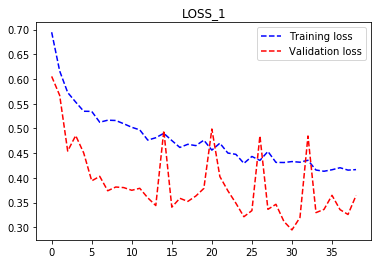

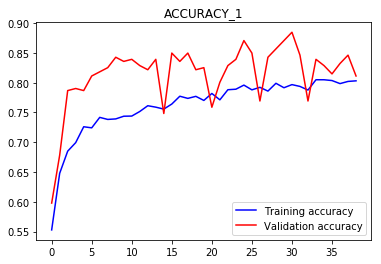

352/352 [==============================] - 2s 5ms/step
test_acc 0.8465909090909091


In [0]:
#@title Set folder name in the working directory in which results will be saved(it will be created if non existing), specify to save the .h5 model or not,set the model number and start training 

folder_name = 'Pt_models_5' #@param{type:"string"}

#@markdown Set *save_last* to True if you want to save the keras models at their last epoch, False otherwise
save_last       = True #@param {type:"boolean"}

#@markdown Set *save_best* to True if you want to save the models at their maximum validation accuracy , False otherwise
save_best       = True #@param {type:"boolean"}
# keras optimizers           'SGD','RMSprop','Adagrad','Adadelta','Adam','Adamax','Nadam'
# default learning rates     0.01  ,0.001   ,0.01     ,1.0       ,0.001  ,0.002   ,0.002
# Possible models : ['Xception' , 'VGG16' , 'VGG19' , 'MobileNetV2' ,'DenseNet121' ]
#featurewise_center, featurewise_std_normalization, rotation_range, width_shift_range, height_shift_range, horizontal_flip, shear_range, zoom_range,  preprocessing_function
      
model_number = 1 #@param {type:"integer"}

#@markdown Set *remove_last_n_blocks* to True if you want to remove the last n blocks of layers of the p.t.CNN's conv. base(with n specified by *n_blocks_remove*)
remove_last_n_blocks = False #@param {type:"boolean"}
n_blocks_remove = 1 #@param {type:"integer"}

#@markdown Set *fine_tuning_last_n_blocks* to True if you want to do fine tuning of the last n blocks of layers of the p.t.CNN's conv. base(with n specified by *n_blocks_tune*)
fine_tuning_last_n_blocks = True #@param {type:"boolean"}
n_blocks_tune = 1 #@param {type:"integer"}

pt_cnn = PT_CNN(train_images_150,train_labels,test_images_150,test_labels)

pt_cnn.data_manipulation()

models_dict = pt_cnn.PT_create_models_and_plots(folder_name , Mod_arch , Mod_train , save_last ,
                                                save_best , model_number , remove_last_n_blocks ,
                                                n_blocks_remove , fine_tuning_last_n_blocks , n_blocks_tune )




# SECTION 3 : The proposed pre-trained CNN

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
VGG16_ConvBase (Model)       (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________
Training process details :
{'epochs': 50, 'batch_size': 100, 'opt_alg': {'algorithm': 'Adamax', 'learning rate': 0.0002}, 'val_split': 0.1, 'data_aug': True, 'early_stopping': {'monitor': 'loss', 'patience': 10}, 'data_aug_specs': {'

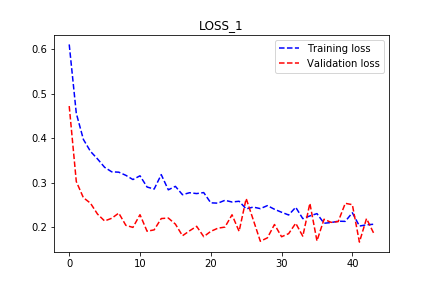

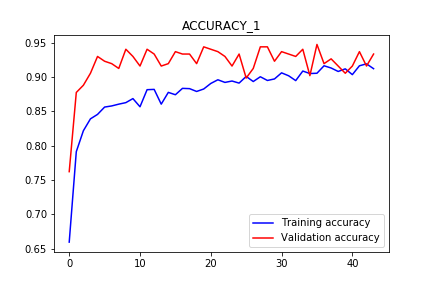

352/352 [==============================] - 2s 6ms/step
test loss is :  0.3655068142847581
test accuracy is :  0.8863636363636364


In [0]:
#@title The best pre-trained CNN 

#@markdown Set the name of the folders in which models have been stored

pt_cnn = PT_CNN(train_images_150,train_labels,test_images_150,test_labels)

pt_cnn.data_manipulation()

models_folder_name = 'Best_PT_models' #@param {type:"string"}
all_models_dictionaries = build_dict(data_dir,models_folder_name)

best_model_dict = best_acc_model(all_models_dictionaries , 1 )[0]

best_model_folder_path = best_model_dict['path']['model_path']
best_model_number = best_model_dict['path']['model_number']

best_model = load_model(best_model_folder_path+'model_'+ best_model_number +'.h5')

#@markdown Set the name of the folder in which to store the final CNN
final_folder = 'final_PT' #@param {type : "string" }
dir_name = data_dir + final_folder + '/'
if not os.path.exists(dir_name) :
  os.mkdir(dir_name)
best_model.save(data_dir + final_folder + '/' + 'best_model.h5')  
json.dump(best_model_dict, open(dir_name + 'Model_dict', 'w+'))
best_model.summary()
print('Training process details :')
print(best_model_dict['mod_training'])

from google.colab.patches import cv2_imshow
import cv2

training_loss_history = cv2.imread(best_model_folder_path+'loss_'+ best_model_number +'.png', cv2.IMREAD_UNCHANGED)
cv2_imshow(training_loss_history)
cv2.imwrite(dir_name+'loss.png',training_loss_history)

training_acc_history = cv2.imread(best_model_folder_path+'acc_'+ best_model_number +'.png', cv2.IMREAD_UNCHANGED)
cv2_imshow(training_acc_history)
cv2.imwrite(dir_name+'acc.png',training_acc_history)

test_loss, test_acc = best_model.evaluate(pt_cnn.test_data,pt_cnn.test_labels)

print('test loss is : ' , test_loss)
print('test accuracy is : ' , test_acc)


